<a href="https://colab.research.google.com/github/moey920/Object-Detection/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4_%EC%B2%98%EB%A6%AC_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C%EC%9A%B0%EB%A1%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한글 텍스트 분류 튜토리얼

## 소개

이번 시간에는 한글 텍스트를 가지고 감정분류를 하는 딥러닝 모델을 구현해보도록 하겠습니다.

이 튜토리얼은 텐서플로 Estimator와 영수증 데이터셋을 활용하여 딥러닝 모델로 어떻게 카테고리를 분류 하는지 봅니다. 

튜토리얼 시작에 앞서서 어떻게 진행하는지에 대해서 아래 목차를 확인하고 가도록 합시다.

1. 데이터 불러오기 - 영수증 데이터셋을 어떻게 불러와 다루는지 보도록 합니다.

2. 데이터 분석

  2.1 리뷰 길이 분포 - 전체 데이터 길이가 어떠한 분포로 되어있는지 확인해보도록 합니다.
  
  2.2 데이터 라벨 분포 - 데이터 학습 라벨 분포가 어떻게 되어있는지 확인해보도록 합니다.
  
  2.3 워드클라우드 - 데이터에 가장 빈번하게 등장하는 단어들이 어떤건지 확인해보도록 합니다.
  
  2.4 기타 - 그 외에 어떠한 데이터를 알아 볼 수 있는지 봅시다.
  
3. 전처리

  3.1 형태소 분석 - 형태소 분석을 통해 한글 토크나이징을 어떻게 하는지 보도록 합니다. 
  
  3.2 불용어 처리 - 어떤 단어를 불용어라 보는지 확인하고 어떻게 데이터에서 제거하는지 보도록 합니다.
  
  3.3 인덱싱 - 모델에 학습하기 위해 단어 사전을 어떻게 구성하는지 보고 텍스트를 어떻게 인덱싱하는지 보도록 합니다.
  
4. 모델 학습 - 모델링은 tf.Estimator를 통해 어떻게 데이터를 입력하고 모델 학습을 하는지 보도록 합니다.

  4.1 데이터 입력 함수 - 모델 학습과 평가를 위해 어떻게 데이터를 구성하는지 알아보도록 합니다.
  
  4.2 모델 함수 - CNN 모델을 어떻게 만드는지 보고 이 모델로 어떻게 텍스트 분류기를 만드는지 보도록 합니다.
  
  4.3 학습 및 평가 - tf.Estimator를 가지고 어떻게 모델 학습과 평가를 하는지 보도록 합니다.
  


In [1]:
!pip install konlpy

     |████████████████████████████████| 19.4MB 157kB/s 
     |████████████████████████████████| 92kB 13.8MB/s 
     |████████████████████████████████| 2.4MB 47.2MB/s 
  Found existing installation: tweepy 3.6.0
    Uninstalling tweepy-3.6.0:
      Successfully uninstalled tweepy-3.6.0
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3


In [2]:
# 나눔고딕 설치
!apt -qq -y install fonts-nanum > /dev/null
# apt가 작동하지 않는데, 일단은 그냥 다음 코드로 진행하셔도 괜찮습니다.
#!pip install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

## 시작에 앞서...

아마 튜토리얼을 처음 시작 하시는 분은 텐서플로우를 거의 다뤄보시지 않은 분들일 겁니다. 

여기서는 딥러닝 모델링을 위해 tf.data, tf.estimator 위주로 주로 다루게 되는데요.

이와 관련해서 대략 tf.data와 tf.estimator가 어떤것인지 알 수 있는 실습 페이지를 두었습니다.

아래 링크를 확인해주시고 각 모듈들이 어떻게 동작하는지를 이해해보았으면 좋겠습니다.

- tf.data 링크: https://bit.ly/2Uuliqa 

- tf.estimator 링크: https://bit.ly/2sWmnLJ 


### Estimator 도식화
![estimator](https://t1.daumcdn.net/cfile/tistory/9910C53359AF8CA334)

## 라이브러리 불러오기

여러분들이 텍스트 분류기를 만들기 위해서는 다음과 같은 라이브러리들이 필요합니다.

- numpy: 벡터 연산 및 여러 수학 연산에서 많이 사용합니다.

- pandas: raw 테이블 데이터를 입력받고 처리하는데 사용합니다.

- matplotlib: 데이터 분석 시에 통계를 보는데 사용합니다.

- wordcloud: 단어 분포를 보는데 사용합니다.

In [0]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

## 데이터 불러오기

판다스 라이브러리를 통해 텍스트 데이터를 불러오도록 합니다.

(현재 텍스트 데이터는 깃헙에 저장된 csv 파일을 불러오는겁니다.)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
#path = '/content/drive/My Drive/text/dataset_utf8.csv'
#with open(path, 'r', encoding='utf-8') as f:
#    train_file_link  = f.readlines()
train_file_link = '/content/drive/My Drive/text/dataset.txt'

불러온 데이터를 보면 id, document, label로 구분이 되어있습니다.

In [6]:
train_data = pd.read_csv(train_file_link, header = 0, delimiter = '\t', quoting = 3)
train_data.head(10)

,id,document,label
0,1,CJ올리브영( ) 정주신봉네거리점,1
1,2,성북도 청주시 흥덕구 사운로 303,2
2,3,6098101574 구장고 TEL : 043- 260 - 15,3
3,4,2020- 02 - 29 20 : 17 : 29 POS : 1001 -00081 M...,4
4,5,고객센터 : 1577 - 4887 www .eliveyoung . co . KI,0
5,6,교환/ 환불은 결제일로부터 15일(3월 15일) 내,0
6,7,판매가능한 정상품( 미개봉) 에 한해 결제했던,0
7,8,수단과 구매영수증 지참 후 매장 방문시 가능,0
8,9,* 단 환불/ 결제수단 변경은 구매매장에서만,0
9,10,가능.,0


## 데이터 분석

불러온 텍스트 데이터를 이제 하나하나 분석을 해보며 이 데이터는 어떻게 구성이 되어있는지 알아가보도록 합시다.

### 학습 데이터 갯수

In [7]:
print('전체 학습데이터의 개수: {}'.format(len(train_data)))

전체 학습데이터의 개수: 5059


### 텍스트 길이 분포

텍스트 분류 모델링을 하는 경우 전체 학습 데이터 길이가 어떻게 되는지 아는게 중요할 때가 있습니다. 

여기서는 Character 단위 Word 단위 2가지로 나누어 분포를 확인해보고자 합니다.

In [8]:
print('id' in train_data.columns)

True


#### Character 단위 텍스트 길이 분포

In [0]:
train_lenght = train_data['document'].astype(str).apply(len)

Text(0, 0.5, 'Number of sentense')

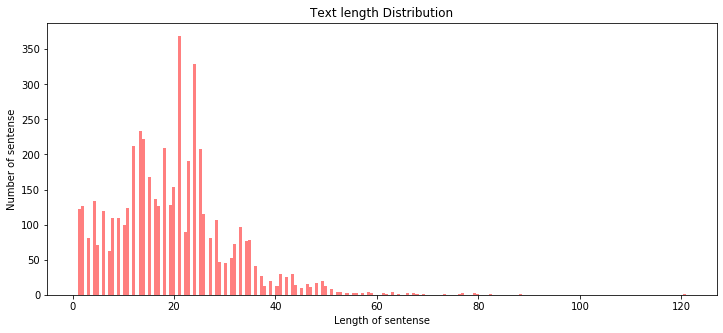

In [10]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_lenght, bins=200, alpha=0.5, color= 'r', label='word')
# plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Text length Distribution')
# 그래프 x 축 라벨
plt.xlabel('Length of sentense')
# 그래프 y 축 라벨
plt.ylabel('Number of sentense')

In [11]:
print('문장 길이 최대 값: {}'.format(np.max(train_lenght)))
print('문징 길이 최소 값: {}'.format(np.min(train_lenght)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_lenght)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_lenght)))
print('문장 길이 중간 값: {}'.format(np.median(train_lenght)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_lenght, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_lenght, 75)))

문장 길이 최대 값: 121
문징 길이 최소 값: 1
문장 길이 평균 값: 19.41
문장 길이 표준편차: 11.28
문장 길이 중간 값: 19.0
문장 길이 제 1 사분위: 12.0
문장 길이 제 3 사분위: 25.0


#### Word 단위 텍스트 길이 분포

In [0]:
train_word_counts = train_data['document'].astype(str).apply(lambda x:len(x.split(' ')))

Text(0, 0.5, 'Number of sentense')

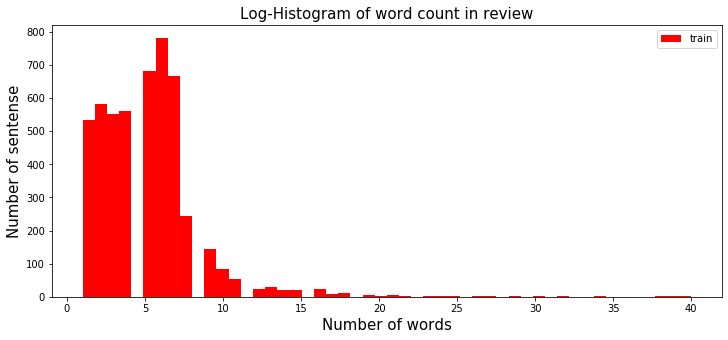

In [13]:
plt.figure(figsize=(12, 5))
plt.hist(train_word_counts, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review', fontsize=15)
# plt.yscale('log', nonposy='clip')
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Number of sentense', fontsize=15)

In [14]:
print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 최소 값: {}'.format(np.min(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))

문장 단어 개수 최대 값: 40
문장 단어 개수 최소 값: 1
문장 단어 개수 평균 값: 5.12
문장 단어 개수 표준편차: 3.38
문장 단어 개수 중간 값: 5.0
문장 단어 개수 제 1 사분위: 3.0
문장 단어 개수 제 3 사분위: 7.0


### 데이터 라벨 분포

이 영수증 텍스트 데이터 라벨은 15 종류로 되어 있습니다.

1. 브랜드명, 지점명
2. 주소
3. 사업자등록번호, 지점대표, 전화번호
4. 구매일시
5. 상품명
6. 상품바코드, 단가, 수량, 금액
7. 결제금액
8. 카드금액
9. 카드번호
10. 카드사명
11. 카드승인번호
12. 영수증 바코드
13. 결제방법
14. 현금영수증 승인번호  
0: 불필요 
로 분류했습니다.


각 데이터 라벨의 분포가 어떠한지 살펴봅시다.

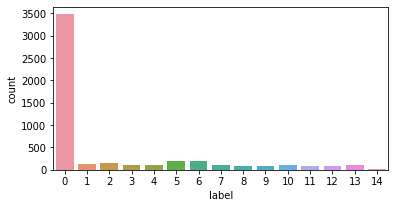

In [15]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 3)
sns.countplot(train_data['label'])

In [18]:
print("불필요 개수: {}".format(train_data['label'].value_counts()[0]))
print("브랜드명, 지점명 개수: {}".format(train_data['label'].value_counts()[1]))
print("주소 개수: {}".format(train_data['label'].value_counts()[2]))
print("사업자등록번호, 지점대표, 전화번호 개수: {}".format(train_data['label'].value_counts()[3]))
print("구매일시 개수: {}".format(train_data['label'].value_counts()[4]))
print("상품명 개수: {}".format(train_data['label'].value_counts()[5]))
print("상품바코드, 단가, 수량, 금액 개수: {}".format(train_data['label'].value_counts()[6]))
print("결제금액 개수: {}".format(train_data['label'].value_counts()[7]))
print("카드금액 개수: {}".format(train_data['label'].value_counts()[8]))
print("카드번호 개수: {}".format(train_data['label'].value_counts()[9]))
print("카드사명 개수: {}".format(train_data['label'].value_counts()[10]))
print("카드승인번호 개수: {}".format(train_data['label'].value_counts()[11]))
print("영수증 바코드 개수: {}".format(train_data['label'].value_counts()[12]))
print("결제방법 개수: {}".format(train_data['label'].value_counts()[13]))
print("현금영수증 승인번호 개수: {}".format(train_data['label'].value_counts()[14]))


불필요 개수: 3475
브랜드명, 지점명 개수: 122
주소 개수: 142
사업자등록번호, 지점대표, 전화번호 개수: 108
구매일시 개수: 107
상품명 개수: 208
상품바코드, 단가, 수량, 금액 개수: 207
결제금액 개수: 99
카드금액 개수: 89
카드번호 개수: 89
카드사명 개수: 97
카드승인번호 개수: 91
영수증 바코드 개수: 96
결제방법 개수: 117
현금영수증 승인번호 개수: 12


### 워드클라우드

과연 이 데이터에는 어떤 말들이 많이 쓰이고 있을까요?

워드클라우드는 데이터에 어떤 단어들이 많이 분포되어있는지 바로 알 수 있게 해줍니다.

워드클라우드를 통해서 어떤 단어가 가장 많이 쓰이는지 살펴보도록 합시다.

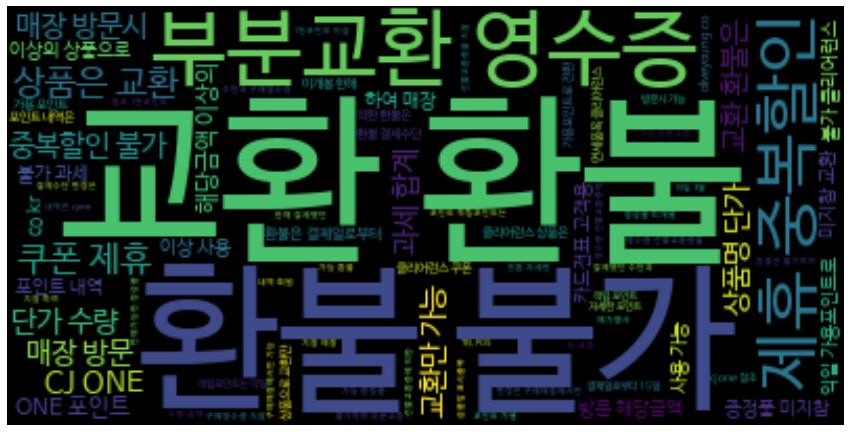

In [19]:
train_review = [review for review in train_data['document'] if type(review) is str]
wordcloud = WordCloud(font_path=fontpath).generate(' ' .join(train_review))
plt.figure(figsize = (15 , 10))
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis('off')
plt.show()

### 기타

텍스트 문장에는 종종 문장의 끝의 기호가 마침표냐 물음표냐 등에 따라 텍스트가 어떤 의미를 가졌는지 대략 짐작을 할 때도 있습니다.

이 텍스트 데이터셋 같은 경우는 어떤지 한 번 보도록 합시다.

In [24]:
qmarks = np.mean(train_data['document'].astype(str).apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
fullstop = np.mean(train_data['document'].astype(str).apply(lambda x: '.' in x)) # 마침표
empty = np.mean(train_data['document'].astype(str).apply(lambda x: ' ' in x)) # 스페이스
                  
print('물음표가 있는 영수증: {:.2f}%'.format(qmarks * 100))
print('마침표가 있는 영수증: {:.2f}%'.format(fullstop * 100))
print('공백이 있는 영수증: {:.2f}%'.format(empty * 100))

물음표가 있는 영수증: 0.08%
마침표가 있는 영수증: 7.75%
공백이 있는 영수증: 89.42%


## 데이터 전처리

텍스트 분류기 모델 학습을 위해 데이터를 모델에 학습시킬 수 있도록 구성해주어야 합니다.

여기서는 텍스트 필터링과 토크나이징, 불용어처리 등을 다루고, 인덱싱처리를 통해 모델에 들어 갈 입력 데이터를 구성합니다.

### 잠깐! 용어 정리

- 배치(batch): 모델 학습에 한 번에 입력할 데이터셋

- 에폭(epoch): 모델 학습시 전체 데이터를 학습한 횟 수

- 스텝(step): (모델 학습의 경우) 하나의 배치를 학습한 횟 수

- 토큰(token): (여기서는) 문장 또는 문단의 기본 구성 단위 (예를 들어 단위, 형태소)

- 토크나이징(tokenizing): 문단 또는 문장 문자열을 하나의 토큰 단위로 쪼개는 작업

- 인덱싱(indexing): 토큰 문자열을 숫자(인덱스)로 변환하여 표현하는 작업

- 사전(vocabulary): 토큰 문자열과 인덱스의 관계를 정의해둔 셋

- n-그램(n-gram): 입력한 문자열을 N개의 기준 단위로 절단하는 방법

### 전처리를 위한 라이브러리

- konlpy: 형태소 단위로 토크나이징을 하기 위해 필요한 라이브러리 입니다.
- tensorflow.python.keras.preprocessing: 단어사전을 만들고 인덱싱을 위해 필요한 모듈입니다.
- tqdm: Progress Bar 라이브러리 입니다.

In [25]:
import re
import json
from konlpy.tag import Okt
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.preprocessing.text import Tokenizer

from tqdm import tqdm

In [26]:
train_data.head(10)

,id,document,label
0,1,CJ올리브영( ) 정주신봉네거리점,1
1,2,성북도 청주시 흥덕구 사운로 303,2
2,3,6098101574 구장고 TEL : 043- 260 - 15,3
3,4,2020- 02 - 29 20 : 17 : 29 POS : 1001 -00081 M...,4
4,5,고객센터 : 1577 - 4887 www .eliveyoung . co . KI,0
5,6,교환/ 환불은 결제일로부터 15일(3월 15일) 내,0
6,7,판매가능한 정상품( 미개봉) 에 한해 결제했던,0
7,8,수단과 구매영수증 지참 후 매장 방문시 가능,0
8,9,* 단 환불/ 결제수단 변경은 구매매장에서만,0
9,10,가능.,0


### RegEx(정규표현식)를 활용한 텍스트 필터링

모델에서 다뤄야 할 단어가 너무 많아도 문제가 되는 경우가 있습니다.

이를 제어하기 위해 한글 데이터만을 받도록 regex를 통해 처리합니다.

* 영수증은 다뤄야 할 데이터에 영어가 포함되어 있는 경우도 있기 때문에 이 과정은 넘어가도록 하겠습니다.

In [28]:
review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", train_data['document'][0]) 
print(review_text)

올리브영  정주신봉네거리점


### KoNLPy를 활용한 토크나이징

한글은 문장에서 단어들로 정의하여 분리하는게 쉽지 않습니다.

공백단위로 쪼개어 단어로 분리할 수 있기도 하지만 여기서는 형태소 분석기를 활용하여 단어로 분리해보도록 하겠습니다.

KoNLPy를 활용하여 토크나이징 하는 방법을 알아봅시다.

In [29]:
okt=Okt()
review_text = okt.morphs(review_text, stem=True)
print(review_text)

['올리브영', '정주', '신봉', '네거리', '점']


### 불용어 사전을 활용한 텍스트 필터링

In [30]:
stop_words = set(['은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한'])
clean_review = [token for token in review_text if not token in stop_words]
print(clean_review)

['올리브영', '정주', '신봉', '네거리', '점']


### 위 세 과정을 세트로 하면...

In [0]:
def preprocessing(review, okt, remove_stopwords = False, stop_words = []):
    # 함수의 인자는 다음과 같다.
    # review : 전처리할 텍스트
    # okt : okt 객체를 반복적으로 생성하지 않고 미리 생성후 인자로 받는다.
    # remove_stopword : 불용어를 제거할지 선택 기본값은 False
    # stop_word : 불용어 사전은 사용자가 직접 입력해야함 기본값은 비어있는 리스트
    
    # 1. 한글 및 공백을 제외한 문자 모두 제거.
    review_text = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", "", review)
    
    # 2. okt 객체를 활용해서 형태소 단위로 나눈다.
    word_review = okt.morphs(review_text, stem=True)
    
    if remove_stopwords:
        
        # 불용어 제거(선택적)
        word_review = [token for token in word_review if not token in stop_words]
        
   
    return word_review

In [32]:
stop_words = [ '은', '는', '이', '가', '하', '아', '것', '들','의', '있', '되', '수', '보', '주', '등', '한']
okt = Okt()
clean_train_review = []

for review in tqdm(train_data['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_train_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_train_review.append([])  #string이 아니면 비어있는 값 추가

100%|██████████| 5059/5059 [00:06<00:00, 785.36it/s] 


### 단어 사전 생성 및 인덱싱

이제 텍스트 데이터를 딥러닝 모델에 입력할 수 있도록 만들어 봅시다.

여기서는 텐서플로의 Tokenizer를 통해 단어 인덱싱 작업을 합니다.

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train_review)
train_sequences = tokenizer.texts_to_sequences(clean_train_review)
train_labels = np.array(train_data['label']) # 학습 데이터의 라벨

### 패딩 작업

여러분이 만약에 모델학습을 하게된다면 학습데이터를 한 문장씩 입력하여 학습하지 않습니다. 
여러 문장을 한번에 묶어서 모델에 입력하게 되는데 이 입력하는 데이터 입력 셋 단위를 '배치'라 합니다.

여러 문장 데이터를 하나의 배치로 구성하게 되면 각 문장의 길이가 각각 다르게 되어 있는걸 확인 하실 수 있습니다.
하지만, 각 문장 입력 데이터 길이가 다르다면 모델 연산을 하는데 문제가 생깁니다. 
왜냐하면 모델은 입력 사이즈가 고정되어 연산되는 걸 선호하기 때문에 그렇습니다.

이러한 문제 때문에 가급적 고정된 문장 길이를 정해두고 입력 문장의 길이를 맞추는 것이 가장 좋습니다.
문장이 긴 경우에는 고정된 문장 길이만큼 자르면 되지만 짧은 경우에는 그렇지 않습니다.
패딩 작업은 이러한 짧은 문장에 대해서 '<PAD\>'와 같은 토큰을 길이를 맞추는 작업입니다.

여기서는 간단하게 pad_sequences 함수가 고정된 길이 만큼의 각 문장 데이터 길이를 맞춰줍니다.

* 위에서 문장 길이를 확인해봤듯이 최대 길이는 121, 평균 길이는 19였습니다. 영수증의 한 문장이 중간에서 짤리지 않도록 여유롭게 60으로 설정해주었습니다.



In [0]:
MAX_SEQUENCE_LENGTH = 60 # 문장 최대 길이

train_inputs = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화

## 모델 학습을 위한 준비

### 모델링을 위한 라이브러리

- tensorflow: 딥러닝 모델링을 위한 라이브러리
- sklearn.model_selection.train_test_split: 데이터를 학습용과 평가용으로 나누기 위한 함수

In [35]:
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split

tf.VERSION

'1.15.0'

In [0]:
input_data = train_inputs
label_data = train_labels
word_vocab = tokenizer.word_index

### 하이퍼파라메터 설정

아래 상수들은 모델에 필요한 하이퍼파라메터 값들입니다.

하이퍼파라메터는 다음과 같이 구성되어 있습니다.

- TEST_SPLIT : 전체 데이터 중 얼마나 평가 데이터로 활용할 지 정하는 상수(0~1)

- RNG_SEED : 데이터 분리를 하는데 랜덤 생성 시드 번호를 고정해두는 상수

- VOCAB_SIZE : 단어 임베딩 총 단어수에 대한 상수

- EMB_SIZE : 단어 임베딩 및 CNN 네트워크 출력 임베딩 차원에 대한 상수

- BATCH_SIZE : 학습 시 모델에 한 번 입력할 데이터 양, 배치 사이즈 상수

- NUM_EPOCHS: 전체 데이터를 몇 번 학습 시킬 것인지 정하는(에포크)) 상수

In [0]:
TEST_SPLIT = 0.1
RNG_SEED = 13371447
VOCAB_SIZE = len(word_vocab) + 1
EMB_SIZE = 128
BATCH_SIZE = 16
NUM_EPOCHS = 1

### 학습 및 평가 데이터 분리

데이터를 학습과 평가 데이터로 구분해줍니다.

여기서는 10%의 데이터만 평가 데이터로 사용합니다.

In [0]:
input_train, input_eval, label_train, label_eval = train_test_split(input_data, label_data, test_size=TEST_SPLIT, random_state=RNG_SEED)

### 데이터 입력 함수

데이터를 모델에 입력할 준비를 해봅시다.                                                                                                                   

tf.estimator를 활용하여 모델링을 하기 위해선 데이터 입력 함수를 선언해줘야 합니다.

데이터 입력 함수 내부는 전부 tf.data.Datset으로 다루어져 있습니다.

앞에서 tf.data를 이미 보셨다면 구현 내용은 쉽게 이해하실 수 있을겁니다.

In [0]:
def mapping_fn(X, Y):
    input, label = {'x': X}, Y
    return input, label

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_train, label_train))
    dataset = dataset.shuffle(buffer_size=len(input_train))
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.map(mapping_fn)
    dataset = dataset.repeat(count=NUM_EPOCHS)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((input_eval, label_eval))
    dataset = dataset.batch(128)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

## 모델 학습

이제 모델링을 직접 해보도록 하겠습니다.

두 개의 모델을 소개하는데 첫 번째 모델은 Convolutional Neural Network를 활용한 분류 모델이고 

두 번째 모델은 Recurrent Neural Network를 활용한 분류 모델입니다.

(참고로 모델은 실제 논문에 나온 모델을 간소화해둔 모델입니다.)

모델을 간단하게 이해하고 본격적으로 모델 학습을 해보도록 합니다.

### Convolutional Neural Network (CNN) 모델

![cnn_model](http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM.png)

### 모델 함수

이제 tf.estimator에 등록할 모델 함수를 구현해 봅시다.

여기서는 CNN 분류 모델을 간소하게 만든 모델입니다.

처음 하시는 분은 CNN 분류를 텐서플로우로 어떻게 구현하는지 보시기 바랍니다.

이미 다뤄보신 분이라면 어떻게 하면 보다 성능이 좋아질 수 있을지 고민해보시면 좋을 것 같습니다.

In [0]:
def cnn_model_fn(features, labels, mode, params):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT

    embedding_layer = tf.keras.layers.Embedding(
                    VOCAB_SIZE,
                    EMB_SIZE)(features['x'])

    dropout_emb = tf.keras.layers.Dropout(rate = 0.2)(embedding_layer)
    
    conv = tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', 
                                  activation=tf.nn.relu)(dropout_emb)
    
  
    pool = tf.keras.layers.GlobalMaxPool1D()(conv)

    hidden = tf.keras.layers.Dense(units=250, activation=tf.nn.relu)(pool)   


    dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(hidden, training = TRAIN)
    logits = tf.keras.layers.Dense(units=1)(dropout_hidden)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        
    if TRAIN:
        global_step = tf.train.get_global_step()
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss = loss)
    
    elif EVAL:
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        pred = tf.nn.sigmoid(logits)
        accuracy = tf.metrics.accuracy(labels, tf.round(pred))
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops={'acc': accuracy})
        
    elif PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'prob': tf.nn.sigmoid(logits),
            }
        )

### tf.Estimator 생성

모델 함수를 만들었다면 tf.estimator를 어떻게 쓰는지 봅시다.

간단하게 tf.estimator.Estimator는 모델 함수를 등록하면서 생성하면 됩니다.

In [41]:
cnn_est = tf.estimator.Estimator(cnn_model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp80itkyrb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f8e8ebac048>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### 모델 학습

tf.estimator는 학습과 평가, 예측에 대한 기능을 간편하게 estimator.train(), estimator.evaluate(), estimator.predict()로 실행할 수 있게 지원하고 있습니다.

이러한 기능 제공 덕분에 여러분은 모델 학습과 평가를 위한 구현에 대한 고민을 굳이 하실 필요가 없습니다.

In [42]:
cnn_est.train(train_input_fn)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmp80itkyrb/model

### 학습 데이터로 평가점수 확인

지금 평가하는 데이터는 학습 데이터입니다.

앞에서 loss값은 확인했지만 정확도에 대해서는 확인해보지 못해 여기서 확인해 보도록 합니다.

In [43]:
cnn_est.evaluate(eval_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-03T01:44:21Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp80itkyrb/model.ckpt-285
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-03-03-01:44:21
INFO:tensorflow:Saving dict for global step 285: acc = 0.019762846, global_step = 285, loss = -38384.293
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 285: /tmp/tmp80itkyrb/model.ckpt-285


{'acc': 0.019762846, 'global_step': 285, 'loss': -38384.293}

### 모델 평가

이제 실제 평가 데이터를 가지고 성능을 측정해보도록 합시다.

In [0]:
test_file_link = 'https://raw.githubusercontent.com/NLP-kr/tensorflow-ml-nlp/master/4.TEXT_CLASSIFICATION/data_in/ratings_test.txt'

### 평가 데이터 구성

In [45]:
test_data = pd.read_csv(test_file_link, header = 0, delimiter = '\t', quoting = 3)

clean_test_review = []

for review in tqdm(test_data['document']):
    # 비어있는 데이터에서 멈추지 않도록 string인 경우만 진행
    if type(review) == str:
        clean_test_review.append(preprocessing(review, okt, remove_stopwords = True, stop_words=stop_words))
    else:
        clean_test_review.append([])  #string이 아니면 비어있는 값 추가

test_sequences = tokenizer.texts_to_sequences(clean_test_review)
test_inputs = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post') # 학습 데이터를 벡터화
test_labels = np.array(test_data['label']) # 학습 데이터의 라벨

100%|██████████| 50000/50000 [02:43<00:00, 306.49it/s]


### 데이터 입력 함수 

In [0]:
def test_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_labels))
    dataset = dataset.batch(128)
    dataset = dataset.map(mapping_fn)
    iterator = dataset.make_one_shot_iterator()
    
    return iterator.get_next()

### CNN 분류기 평가

In [47]:
cnn_est.evaluate(test_input_fn)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2020-03-03T01:48:51Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp80itkyrb/model.ckpt-285
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2020-03-03-01:48:52
INFO:tensorflow:Saving dict for global step 285: acc = 0.50346, global_step = 285, loss = 14301.782
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 285: /tmp/tmp80itkyrb/model.ckpt-285


{'acc': 0.50346, 'global_step': 285, 'loss': 14301.782}

## 직접 쓴 문장을 가지고 예측해보기

### 서빙 함수 구현

In [0]:
# Serving을 제공하기 위한 입력 리시버 함수를 선언해주어야 한다.
def serving_input_receiver_fn():
    # estimator에 입력하고자 하는 데이터를 dict 객체로 정의한다.
    receiver_tensor = {
        # 외부로부터 입력을 받는 프로토콜은 스트링이다. ServingInputReceiver 메뉴얼에도 언급되었다시피
        # 이 방식은 TFRecord 파일 형태로 시리얼화한 데이터 형태로 전송을 받는다. (이를 tf.example 방식이라고도 하는 것 같다)
        'x': tf.placeholder(dtype=tf.string, shape=[None])
    }
    
    # 다음은 TFRecord 방식으로 받은 데이터를 모델에 넣을 수 있게 처리를 하는 dict 객체라 보면 된다.
    # 쉽게 말하면 앞서 estimator를 진행하기 위해 data_fn의 과정을 작성해두는데 이 과정을 여기서 거친다 보면 된다.
    features = {
        key: tensor
        for key, tensor in receiver_tensor.items()
    }
    # TFRecord로 시리얼화 된 데이터를 integer tensor로 변환하기 위해서는 string to int로 decode를 해줘야 한다.
    fn = lambda query: tf.decode_raw(query, tf.int64)
    features['x'] = tf.map_fn(fn, features['x'], dtype=tf.int64)
    # 받은 데이터에 대해 모델입력에 맞는 shape로 구성을 해주기 위해 reshape을 해준다.
    features['x'] = tf.reshape(features['x'], [-1, MAX_SEQUENCE_LENGTH])

    # 위에 정의한 받을 데이터에 대한 프로토콜과 모델에 입력할 데이터 전처리를 다음 함수 파라메터에 입력해준다.
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensor)

### 서빙할 모델 파일 생성

In [49]:
export_dir_base = './served_model/new_staging'

# 서빙에 대한 입력 리시버함수와 저장 위치를 파라메터로 지정한다면, 서빙 pb파일로 저장하여 간단하게 모델을 활용할 수 있게 된다.
# 실행을 하게 되면 저장된 파일의 위치를 텍스트 출력을 통해 얻게된다.
path = cnn_est.export_savedmodel(export_dir_base, serving_input_receiver_fn)

Instructions for updating:
This function has been renamed, use `export_saved_model` instead.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default']
INFO:tensorflow:Signatures INCLUDED in export for Train: None
INFO:tensorflow:Signatures INCLUDED in export for Eval: None
INFO:tensorflow:Restoring parameters from /tmp/tmp80itkyrb/model.ckpt-285
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./served_model/new_staging/temp-b'1583200148'/saved_model.pb


### 서빙 모델 파일을 예측 모델 함수로 만들기

In [50]:
# 모델이 저장된 경로 위치를 파라메터로 지정하여 함수를 부르면 간단하게 예측 모델을 활용할 수 있다.
# 이 모델 예측을 간단하게 함수로 받게된다.
predictor_fn = tf.contrib.predictor.from_saved_model(
    export_dir = path,
    # 옵션이지만 실행되는 모델에 대한 이름을 명시하고자 한다면 다음의 파라메터를 활용한다.
    signature_def_key="serving_default"
)

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from ./served_model/new_staging/1583200148/variables/variables


### 문장 벡터화

In [0]:
def str2vec(s, okt, tokenizer, limit_len=MAX_SEQUENCE_LENGTH):
  tokenized_s = preprocessing(s, okt)
  sequences = tokenizer.texts_to_sequences([tokenized_s])
  sequences = pad_sequences(sequences, maxlen=limit_len, padding='post')

  return np.int64(sequences).tostring()

### 예측 테스트

In [55]:
test_sent = '결제금액 : 22,600'
model_input = str2vec(test_sent, okt, tokenizer)
predicted_value = predictor_fn({'x': [model_input]})
print('모델에서 반환된 값: ', predicted_value)
print('감정 예측 값 (0~1범위): ',  predicted_value['prob'][0][0])

모델에서 반환된 값:  {'prob': array([[1.]], dtype=float32)}
감정 예측 값 (0~1범위):  1.0


In [56]:
input_str = input('input text : ')
model_input = str2vec(test_sent, okt, tokenizer)
predicted_value = predictor_fn({'x': [model_input]})
print(predicted_value['prob'][0])

input text : 신용카드
[1.]


### Recurrent Neural Network (RNN) 모델

![rnn_image](http://tommymullaney.com/img/google-hangouts-feature.png)

In [0]:
def rnn_model_fn(features, labels, mode, params):
    TRAIN = mode == tf.estimator.ModeKeys.TRAIN
    EVAL = mode == tf.estimator.ModeKeys.EVAL
    PREDICT = mode == tf.estimator.ModeKeys.PREDICT

    embedding_layer = tf.keras.layers.Embedding(
                    VOCAB_SIZE,
                    EMB_SIZE)(features['x'])

    dropout_emb = tf.keras.layers.Dropout(rate = 0.2)(embedding_layer)
  
    lstm = tf.keras.layers.LSTM(32)(dropout_emb)

    hidden = tf.keras.layers.Dense(units=250, activation=tf.nn.relu)(lstm)   


    dropout_hidden = tf.keras.layers.Dropout(rate=0.2)(hidden, training = TRAIN)
    logits = tf.keras.layers.Dense(units=1)(dropout_hidden)

    if labels is not None:
        labels = tf.reshape(labels, [-1, 1])
        
    if TRAIN:
        global_step = tf.train.get_global_step()
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        train_op = tf.train.AdamOptimizer(0.001).minimize(loss, global_step)

        return tf.estimator.EstimatorSpec(mode=mode, train_op=train_op, loss = loss)
    
    elif EVAL:
        loss = tf.losses.sigmoid_cross_entropy(labels, logits)
        pred = tf.nn.sigmoid(logits)
        accuracy = tf.metrics.accuracy(labels, tf.round(pred))
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, eval_metric_ops={'acc': accuracy})
        
    elif PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions={
                'prob': tf.nn.sigmoid(logits),
            }
        )

In [0]:
rnn_est = tf.estimator.Estimator(rnn_model_fn)

In [0]:
rnn_est.train(train_input_fn)

In [0]:
rnn_est.evaluate(eval_input_fn)

In [0]:
rnn_est.evaluate(test_input_fn)